In [1]:
using Pkg
Pkg.status()
using SymPy
using BenchmarkTools, LinearAlgebra, LazyArrays, BandedMatrices
using PyPlot

      Status `~/.julia/environments/v1.7/Project.toml`
  [aae01518] BandedMatrices v0.17.0
  [6e4b80f9] BenchmarkTools v1.3.1
  [8e7c35d0] BlockArrays v0.16.18
  [ce91de38] ColorBitstring v0.1.1
  [7073ff75] IJulia v1.23.3
  [5078a376] LazyArrays v0.22.10
  [a3b82374] MatrixFactorizations v0.9.1
  [91a5bcdd] Plots v1.29.0
  [f27b6e38] Polynomials v3.1.4
  [438e738f] PyCall v1.93.1
  [d330b81b] PyPlot v2.10.0
  [295af30f] Revise v3.3.3
  [f8ebbe35] SemiseparableMatrices v0.3.3
  [3cc68bcd] SetRounding v0.2.1
  [24249f21] SymPy v1.1.6
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [8dfed614] Test


In [2]:
function ppl(context)
    println(sympy.latex(context))
end

ppl (generic function with 1 method)

In [3]:
xx0 = symbols("x_(1:6)", real=True)
yy0 = symbols("y_(1:6)", real=True)
uu0 = symbols("u_(1:6)", real=True)
vv0 = symbols("v_(1:6)", real=True)
pp0 = symbols("p_(1:6)", real=True)
qq0 = symbols("q_(1:6)", real=True)
xs = [i for i in xx0]
ys = [i for i in yy0]
us = [i for i in uu0]
vs = [i for i in vv0]
ps = [i for i in pp0]
qs = [i for i in qq0]

xf = rand(6)
yf = rand(6);

In [4]:
Ss = triu(xs * ys', 1) + tril(ys * xs')

5×5 Matrix{Sym}:
 x₁⋅y₁  x₁⋅y₂  x₁⋅y₃  x₁⋅y₄  x₁⋅y₅
 x₁⋅y₂  x₂⋅y₂  x₂⋅y₃  x₂⋅y₄  x₂⋅y₅
 x₁⋅y₃  x₂⋅y₃  x₃⋅y₃  x₃⋅y₄  x₃⋅y₅
 x₁⋅y₄  x₂⋅y₄  x₃⋅y₄  x₄⋅y₄  x₄⋅y₅
 x₁⋅y₅  x₂⋅y₅  x₃⋅y₅  x₄⋅y₅  x₅⋅y₅

In [5]:
display(triu(us * vs'))
display(tril(ps * qs'))
triu(us * vs') * tril(ps * qs')

5×5 Matrix{Sym}:
 u₁⋅v₁  u₁⋅v₂  u₁⋅v₃  u₁⋅v₄  u₁⋅v₅
       0  u₂⋅v₂  u₂⋅v₃  u₂⋅v₄  u₂⋅v₅
       0        0  u₃⋅v₃  u₃⋅v₄  u₃⋅v₅
       0        0        0  u₄⋅v₄  u₄⋅v₅
       0        0        0        0  u₅⋅v₅

5×5 Matrix{Sym}:
 p₁⋅q₁        0        0        0        0
 p₂⋅q₁  p₂⋅q₂        0        0        0
 p₃⋅q₁  p₃⋅q₂  p₃⋅q₃        0        0
 p₄⋅q₁  p₄⋅q₂  p₄⋅q₃  p₄⋅q₄        0
 p₅⋅q₁  p₅⋅q₂  p₅⋅q₃  p₅⋅q₄  p₅⋅q₅

5×5 Matrix{Sym}:
 p₁⋅q₁⋅u₁⋅v₁ + p₂⋅q₁⋅u₁⋅v₂ + p₃⋅q₁⋅u₁⋅v₃ + p₄⋅q₁⋅u₁⋅v₄ + p₅⋅q₁⋅u₁⋅v₅  …  p₅⋅q₅⋅u₁⋅v₅
                   p₂⋅q₁⋅u₂⋅v₂ + p₃⋅q₁⋅u₂⋅v₃ + p₄⋅q₁⋅u₂⋅v₄ + p₅⋅q₁⋅u₂⋅v₅     p₅⋅q₅⋅u₂⋅v₅
                                     p₃⋅q₁⋅u₃⋅v₃ + p₄⋅q₁⋅u₃⋅v₄ + p₅⋅q₁⋅u₃⋅v₅     p₅⋅q₅⋅u₃⋅v₅
                                                       p₄⋅q₁⋅u₄⋅v₄ + p₅⋅q₁⋅u₄⋅v₅     p₅⋅q₅⋅u₄⋅v₅
                                                                         p₅⋅q₁⋅u₅⋅v₅     p₅⋅q₅⋅u₅⋅v₅

In [6]:
triu(xs * ys') * tril(ys * xs')

5×5 Matrix{Sym}:
 x_1^2*y_1^2 + x_1^2*y_2^2 + x_1^2*y_3^2 + x_1^2*y_4^2 + x_1^2*y_5^2  …  x_1*x_5*y_5^2
       x_1*x_2*y_2^2 + x_1*x_2*y_3^2 + x_1*x_2*y_4^2 + x_1*x_2*y_5^2     x_2*x_5*y_5^2
                       x_1*x_3*y_3^2 + x_1*x_3*y_4^2 + x_1*x_3*y_5^2     x_3*x_5*y_5^2
                                       x_1*x_4*y_4^2 + x_1*x_4*y_5^2     x_4*x_5*y_5^2
                                                       x_1*x_5*y_5^2       x_5^2*y_5^2

In [7]:
Sf = triu(xf * yf', 1) + tril(yf * xf')
rank(Sf)

6

In [8]:
inv(Sf)

6×6 Matrix{Float64}:
  4.82007      -3.20865       4.19526e-17  …  -9.05962e-17   2.67993e-16
 -3.20865      -0.980123      2.20869          1.61353e-18   1.81847e-17
  3.08659e-17   2.20869      -0.00367193      -1.15888e-16   1.38312e-16
 -2.03374e-16  -1.49441e-16  -2.29194          3.70812       6.13729e-17
 -2.43071e-16   1.47952e-16   5.22825e-16      3.74044      -4.64825
  2.85933e-16  -1.03743e-16  -1.85044e-16  …  -4.64825       5.24061

In [9]:
Tridiagonal(inv(Sf))

6×6 Tridiagonal{Float64, Vector{Float64}}:
  4.82007  -3.20865     ⋅            ⋅          ⋅         ⋅ 
 -3.20865  -0.980123   2.20869       ⋅          ⋅         ⋅ 
   ⋅        2.20869   -0.00367193  -2.29194     ⋅         ⋅ 
   ⋅         ⋅        -2.29194     -0.392611   3.70812    ⋅ 
   ⋅         ⋅          ⋅           3.70812    3.74044  -4.64825
   ⋅         ⋅          ⋅            ⋅        -4.64825   5.24061

In [10]:
isposdef(Tridiagonal(inv(Sf)))

false

In [11]:
n = 6
A = Tridiagonal(rand(n,n))
T = Matrix(A + A' + 100*I)
isposdef(T)
C = cholesky(T)
L = C.L
U = C.U
L * L' ≈ T
U' * U ≈ T

true

In [12]:
include("backsub.jl")
include("invBiU.jl")

invBidiagUxy (generic function with 1 method)

In [13]:
U

6×6 UpperTriangular{Float64, Matrix{Float64}}:
 10.0771   0.0689894   0.0         0.0          0.0         0.0
   ⋅      10.0008      0.0565751   0.0          0.0         0.0
   ⋅        ⋅         10.0145      0.00692577   0.0         0.0
   ⋅        ⋅           ⋅         10.0063       0.0944234   0.0
   ⋅        ⋅           ⋅           ⋅          10.0127      0.0194731
   ⋅        ⋅           ⋅           ⋅            ⋅         10.0734

In [14]:
Uinv, xU, yU = invBidiagUxy(U)
Uinv * U ≈ I
Uinv

6×6 Matrix{Float64}:
 0.0992346  -0.000684559   3.86729e-6   …   2.52423e-11  -4.87964e-14
 0.0         0.099992     -0.000564887     -3.68708e-9    7.12759e-12
 0.0         0.0           0.0998553        6.51767e-7   -1.25995e-9
 0.0         0.0           0.0             -0.00094244    1.82185e-6
 0.0         0.0           0.0              0.0998728    -0.000193067
 0.0         0.0           0.0          …   0.0           0.0992717

In [15]:
L

6×6 LowerTriangular{Float64, Matrix{Float64}}:
 10.0771       ⋅           ⋅            ⋅           ⋅           ⋅ 
  0.0689894  10.0008       ⋅            ⋅           ⋅           ⋅ 
  0.0         0.0565751  10.0145        ⋅           ⋅           ⋅ 
  0.0         0.0         0.00692577  10.0063       ⋅           ⋅ 
  0.0         0.0         0.0          0.0944234  10.0127       ⋅ 
  0.0         0.0         0.0          0.0         0.0194731  10.0734

In [16]:
Linv0, xL, yL = invBidiagUxy(L')
Linv = Linv0'
Linv * L ≈ I
Linv

6×6 adjoint(::Matrix{Float64}) with eltype Float64:
  0.0992346     0.0           0.0         …   0.0          0.0
 -0.000684559   0.099992      0.0             0.0          0.0
  3.86729e-6   -0.000564887   0.0998553       0.0          0.0
 -2.67671e-9    3.90981e-7   -6.91139e-5      0.0          0.0
  2.52423e-11  -3.68708e-9    6.51767e-7      0.0998728    0.0
 -4.87964e-14   7.12759e-12  -1.25995e-9  …  -0.000193067  0.0992717

In [17]:
# S = triu(xU * yU', 1) + tril(yL * xL')

In [18]:
xL == xU
yL == yU

true

In [19]:
Tinv = Uinv * Linv
# Tinv ≈ triu(xU * yU') * tril(yL * xL')
# Tinv - Tinv'

6×6 Matrix{Float64}:
  0.00984798   -6.84526e-5    3.8617e-7    …   2.52102e-12  -4.8441e-15
 -6.84526e-5    0.00999871   -5.6407e-5       -3.68241e-10   7.07568e-13
  3.8617e-7    -5.6407e-5     0.00997108       6.5094e-8    -1.25077e-10
 -2.67527e-10   3.9077e-8    -6.90766e-6      -9.41244e-5    1.80858e-7
  2.52102e-12  -3.68241e-10   6.5094e-8        0.00997461   -1.9166e-5
 -4.8441e-15    7.07568e-13  -1.25077e-10  …  -1.9166e-5     0.00985487

In [20]:
function getCoef(u, v)
    T = eltype(u)
    n = length(u)
    coef = zeros(T, n)
    coef[n] = u[n]*v[n]
    for i in n-1:-1:1
        coef[i] = coef[i+1] + u[i]*v[i]
    end
    coef
    # println(coef[1] - u'*v)
end

function onepairsym(x, y)
    p = x
    q = x .* getCoef(y,y)
    (p, q)
end

function getSSsym(p, q)
    triu(p * q') + tril(q * p', -1)
    triu(p * q', 1) + tril(q * p')
end

# getCoef(uuu, vvv)
p,q = onepairsym(xU, yU)

getSSsym(p,q) - Tinv

6×6 Matrix{Float64}:
 0.0           0.0           0.0           5.16988e-26  0.0          0.0
 0.0          -1.73472e-18   0.0          -6.61744e-24  0.0          0.0
 0.0           0.0          -1.73472e-18   0.0          1.32349e-23  0.0
 5.16988e-26  -6.61744e-24   0.0          -1.73472e-18  0.0          0.0
 0.0           0.0           1.32349e-23   0.0          0.0          0.0
 0.0           0.0           0.0           0.0          0.0          0.0

In [21]:
function testf1(x, y, i, j, n)
    if i <= j
        s = y[j].^2
        for k in j+1:n
            s += y[k].^2
        end
    else
        s = y[i].^2
        for k in i+1:n
            s += y[k].^2
        end
    end
    x[i]*x[j]*s
end
function testf11(x, y, i, j, n)
    k = max(i, j)
    x[i]*x[j] * (y[k:n])'*y[k:n]
end
i, j = 3, 5
display(Tinv[i,j])
display(testf11(xU, yU, i, j, n))


function testf2(u, v, p, q, i, j, n)
    if i <= j
        s = p[j] * v[j]
        for k in j+1:n
            s += p[k] * v[k]
        end
    else
        s = p[i] * v[i]
        for k in i+1:n
            s += p[k] * v[k]
        end
    end
    q[j]*u[i]*s
end

function testf22(u, v, p, q, i, j, n)
    k = max(i, j)
    q[j]*u[i] * (p[k:n])'*v[k:n]
end

6.509401891585355e-8

6.509401891585355e-8

testf22 (generic function with 1 method)

In [22]:
uuu = rand(n)
vvv = rand(n)
ppp = rand(n)
qqq = rand(n)
AAA = triu(uuu * vvv') * tril(ppp * qqq')


for i in 1:n
    for j in 1:n
        println(Tinv[i,j] ≈ testf11(xU, yU, i, j, n))
        # println(AAA[i,j] ≈ testf22(uuu, vvv, ppp, qqq, i, j, n))
    end
end


true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true


In [23]:
function generateSymSS(x, y)
    # tril(ỹ * x̃') + triu(x̃ * ỹ', 1)
    T = eltype(x)
    n = length(x)
    SS = zeros(T, n, n)
    for i in 1:n
        for j in 1:n
            if i <= j
                SS[i,j] = y[j]*x[i]
            else
                SS[i,j] = y[i]*x[j]
            end
        end
    end
    SS
end

xx = rand(6)
yy = rand(6)

generateSymSS(xx,yy) - triu(xx * yy', 1) - tril(yy * xx')

6×6 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

In [24]:
@btime generateSymSS(xx,yy);
@btime triu(xx * yy', 1) + tril(yy * xx');

  69.757 ns (1 allocation: 368 bytes)
  281.827 ns (7 allocations: 1.83 KiB)


In [25]:
function fl2exp(x)
    sx = sign.(x)
    xE = log.(abs.(x))
    (sx, xE);
end

function exp2fl((sx, xE))
    x = sx .* exp.(xE);
end


function expTimes((sx, xE), (sy, yE))
    sxTy = sx .* sy
    xTyE = xE .+ yE
    (sxTy, xTyE);
end


function expDivide((sx, xE), (sy, yE))
    sxDy = sx .* sy
    xDyE = xE .- yE
    (sxDy, xDyE);
end

function expInv((sx, xE))
    (sx, -xE);
end




function invBidiagUexptest(U)
    T = eltype(U)
    n = size(U)[2]
    e_n = zeros(T, n)
    e_n[n] = one(T)

    
    x = BandBackSubVec(U, e_n, 1)
    y = inv.(U[diagind(U)] .* x)

    # display(x)
    # display(Float64.(x))


    (sx, xE) = fl2exp(x)
    xE = Float64.(xE)
    # println(typeof(xE))

    (sy, yE) = expInv(expTimes(fl2exp(Float64.(U[diagind(U)])), (sx, xE)))
    # println(typeof(yE))

    xEf = exp2fl((sx, xE))
    yEf = exp2fl((sy, yE))
    

    Uinv = zeros(T, n, n)
    for i in 1:n
        for j in i:n
            Uinv[i, j] = x[i] * y[j]
        end
    end

    UinvEs = zeros(n, n)
    UinvEe = zeros(n, n)
    for i in 1:n
        for j in i:n
            Uinvsi, UinvEi = expTimes((sx[i], xE[i]), (sy[j], yE[j]))
            UinvEs[i, j] = Uinvsi
            UinvEe[i, j] = UinvEi

        end
    end
    UinvE = exp2fl((UinvEs, UinvEe))


    UinvEf = zeros(T, n, n)
    for i in 1:n
        for j in i:n
            UinvEf[i, j] = xEf[i] * yEf[j]
        end
    end
    # display(xE)
    display(Uinv)
    display(UinvE)
    # display(UinvEf)
    println(norm(Uinv - UinvE))
    # println(norm(Uinv - UinvEf))

    # ()
end




invBidiagUexptest (generic function with 1 method)

In [173]:
function BiBackSubVecEnExp(U)
    n = size(U)[2]
    # T = eltype(U)
    # x = zeros(T, n)
    sx, xE = zeros(n), zeros(n)

    (sEn, EnE) = (1.0, 0.0)

    # (sU, UE) = fl2exp(U[diagind(U)])

    (sx[n], xE[n]) = expInv(fl2exp(U[n, n]))

    expInv
    for i in n-1 : -1 : 1
            # x[i] = U[i, i+1] * x[i+1] / U[i, i]
            # fl2exp(U[i, i+1])
            # fl2exp(U[i, i])
            (sx[i], xE[i]) = expDivide(expTimes(fl2exp(-U[i, i+1]), (sx[i+1], xE[i+1])), fl2exp(U[i, i]))
    end
    (sx, xE);
    # x;
end

function invBidiagUexp(U)
    n = size(U)[2]
    e_n = zeros(n)
    e_n[n] = 1.0

    x = BandBackSubVec(big.(U), big.(e_n), 1)
    x = BandBackSubVec(big.(U), big.(e_n), 1)

    (sx, xE) = fl2exp(x)
    xE = Float64.(xE)

    (sy, yE) = expInv(expTimes(fl2exp(Float64.(U[diagind(U)])), (sx, xE)))

    Uinv = zeros(n, n)
    for i in 1:n
        for j in i:n
            Uinvsi, UinvEi = expTimes((sx[i], xE[i]), (sy[j], yE[j]))
            Uinv[i, j] = exp2fl((Uinvsi, UinvEi))
        end
    end
    # UinvE = exp2fl((UinvEs, UinvEe))
    display()
    Uinv;
end

invBidiagUexp (generic function with 1 method)

In [162]:
# n=10000
# x = -rand(n)
# y = rand(n)
# display(norm(exp2fl(fl2exp(x)) - x))
# display(norm(exp2fl(expTimes(fl2exp(x), fl2exp(y))) - x .* y))
# display(norm(exp2fl(expDivide(fl2exp(x), fl2exp(y))) - x ./ y))
# display(norm(exp2fl(expTimes(fl2exp(x), expInv(fl2exp(y)))) - x ./ y))



function getU(n)
    U = rand(n,n) + (n/100)*I
    U -= tril(U, -1) 
    U -= triu(U, 2)
    U
end

U = getU(1000)

# @btime UinvE = invBidiagUexp(U)
# @benchmark UinvE = invBidiagUexp(U)
# U = big.(U)
# @btime Uinv = invBidiagU(U)
# @benchmark UinvE = invBidiagU(U)

# U[diagind(U)]
# display(Uinv)
# display(UinvE)
# UinvE * U ≈ I

# Uinv * big.(U) ≈ I

1000×1000 Matrix{Float64}:
 10.0047   0.127947   0.0        0.0       …   0.0         0.0       0.0
  0.0     10.6486     0.378855   0.0           0.0         0.0       0.0
  0.0      0.0       10.1558     0.751027      0.0         0.0       0.0
  0.0      0.0        0.0       10.048         0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  0.0      0.0        0.0        0.0       …   0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  0.0      0.0        0.0        0.0       …   0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  0.0      0.0        0.0        0.0           0.0         0.0       0.0
  ⋮                     

In [184]:
function BiBackSubVecEnExp(U)
    n = size(U)[2]
    # T = eltype(U)
    # x = zeros(T, n)
    sx, xE = zeros(n), zeros(n)

    (sEn, EnE) = (1.0, 0.0)

    # (sU, UE) = fl2exp(U[diagind(U)])

    (sx[n], xE[n]) = expInv(fl2exp(U[n, n]))

    expInv
    for i in n-1 : -1 : 1
        (sx[i], xE[i]) = expDivide(expTimes(fl2exp(-U[i, i+1]), (sx[i+1], xE[i+1])), fl2exp(U[i, i]))
    end
    (sx, xE);
end

function invBidiagUexpmod(U)
    n = size(U)[2]
    (sx, xE) = BiBackSubVecEnExp(U)
    (sy, yE) = expInv(expTimes(fl2exp(U[diagind(U)]), (sx, xE)))

    Uinv = zeros(n, n)
    for i in 1:n
        for j in i:n
            Uinvsi, UinvEi = expTimes((sx[i], xE[i]), (sy[j], yE[j]))
            Uinv[i, j] = exp2fl((Uinvsi, UinvEi))
        end
    end
    Uinv;
end

# U10 = getU(10)
# En = one(U10)[:, 10]
# U10 * (U10 \ En) ≈ En
# x = exp2fl(BiBackSubVecEnExp(U10))
# norm(U10 * x - En)
# U * invBidiagUexpmod(U) ≈ I

@btime UinvEmod = invBidiagUexpmod(U)
UinvEmod = invBidiagUexpmod(U)

  2.443 ms (10 allocations: 7.69 MiB)


1000×1000 Matrix{Float64}:
 0.0999528  -0.00120098   4.48017e-5  …   0.0          -0.0
 0.0         0.0939094   -0.00350323     -0.0           0.0
 0.0         0.0          0.0984661       0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 0.0         0.0          0.0         …  -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0         …   0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 ⋮                                    ⋱                
 0.0         0.0          0.0             3.6846e-16   -1.27932e-17
 0.0         0.0          0.0            -9.97717e-15   3.46415e-16
 

In [185]:
@btime UinvE = invBidiagUexp(U)
# @benchmark UinvE = invBidiagUexp(U)
UinvE = invBidiagUexp(U)



  96.061 ms (6028018 allocations: 344.91 MiB)


1000×1000 Matrix{Float64}:
 0.0999528  -0.00120098   4.48017e-5  …   0.0          -0.0
 0.0         0.0939094   -0.00350323     -0.0           0.0
 0.0         0.0          0.0984661       0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 0.0         0.0          0.0         …  -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0         …   0.0          -0.0
 0.0         0.0          0.0            -0.0           0.0
 0.0         0.0          0.0             0.0          -0.0
 ⋮                                    ⋱                
 0.0         0.0          0.0             3.6846e-16   -1.27932e-17
 0.0         0.0          0.0            -9.97717e-15   3.46415e-16
 

In [186]:
UU = big.(U)
@btime Uinv = invBidiagU(UU)
# @benchmark Uinv = invBidiagU(U)
Uinv = invBidiagU(UU)


  28.467 ms (1011010 allocations: 61.65 MiB)


1000×1000 Matrix{BigFloat}:
 0.0999528  -0.00120098   4.48017e-05  …   1.14699e-1450  -3.98244e-1452
 0.0         0.0939094   -0.00350323      -8.96881e-1449   3.11403e-1450
 0.0         0.0          0.0984661        2.52088e-1447  -8.75268e-1449
 0.0         0.0          0.0             -3.40886e-1446   1.18358e-1447
 0.0         0.0          0.0              3.59947e-1445  -1.24976e-1446
 0.0         0.0          0.0          …  -6.83049e-1444   2.37159e-1445
 0.0         0.0          0.0              7.48413e-1443  -2.59854e-1444
 0.0         0.0          0.0             -1.4172e-1441    4.92061e-1443
 0.0         0.0          0.0              7.98158e-1440  -2.77126e-1441
 0.0         0.0          0.0             -5.26517e-1438   1.8281e-1439
 0.0         0.0          0.0          …   6.35538e-1437  -2.20664e-1438
 0.0         0.0          0.0             -1.35375e-1435   4.70032e-1437
 0.0         0.0          0.0              6.66125e-1432  -2.31284e-1433
 ⋮                      

PyObject <matplotlib.image.AxesImage object at 0x2f7b12c10>

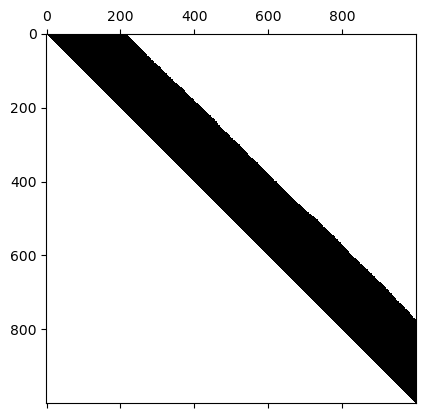

In [188]:
display(spy(UinvE))

PyObject <matplotlib.image.AxesImage object at 0x2f7b5d310>

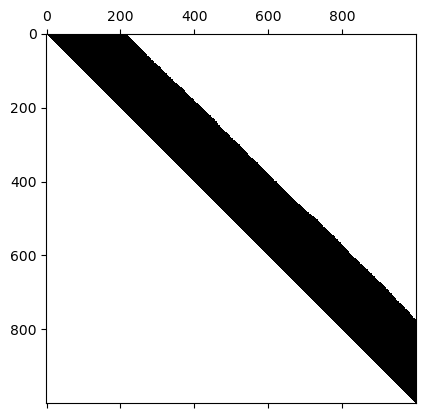

In [189]:
display(spy(UinvEmod))

PyObject <matplotlib.image.AxesImage object at 0x32d42b970>

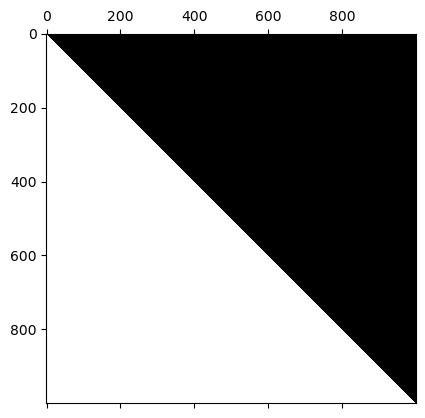

In [190]:
display(spy(Uinv))

In [191]:
display(norm(UinvE * U - I))
display(norm(UinvEmod * U - I))
display(norm(Uinv * U - I))

2.842231081268159e-12

2.8348639668323833e-12

2.015684628062691537371901418425628024138694846221163014221474667757187367895553e-76

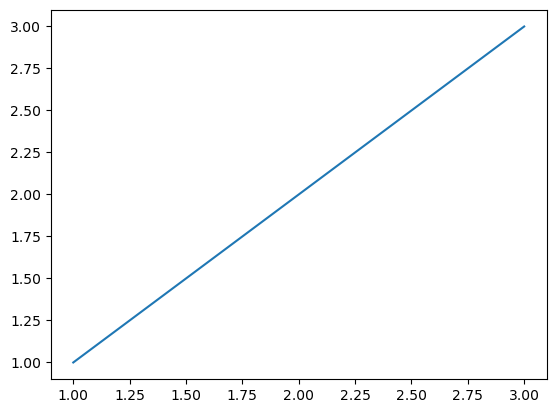

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2f7223f70>

In [130]:
Ut1 = UinvE[1,:]

sum(UinvE.==0) - 1000*999/2

776-1000


In [77]:
m = 3
TTT = Tridiagonal(rand(m,m))


TTT = [-2 1 0; 1 -2 1; 0 1 -2]
III = -one(TTT)

kron(TTT, III) + kron(III, TTT)

9×9 Matrix{Int64}:
  4  -1   0  -1   0   0   0   0   0
 -1   4  -1   0  -1   0   0   0   0
  0  -1   4   0   0  -1   0   0   0
 -1   0   0   4  -1   0  -1   0   0
  0  -1   0  -1   4  -1   0  -1   0
  0   0  -1   0  -1   4   0   0  -1
  0   0   0  -1   0   0   4  -1   0
  0   0   0   0  -1   0  -1   4  -1
  0   0   0   0   0  -1   0  -1   4

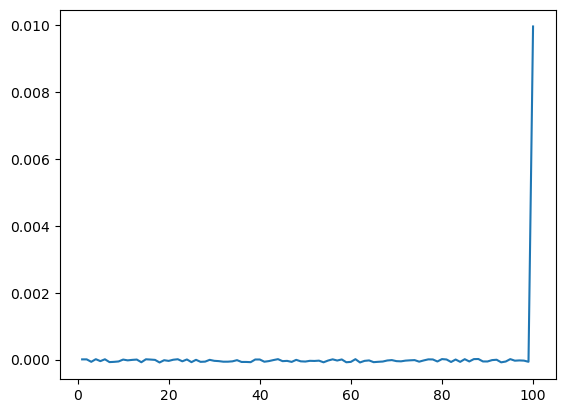

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2f7495b50>

In [141]:
plot(1:100, (rand(100, 100) + 100I) \ one(rand(100,100))[:,end])

In [134]:
(rand(100, 100) + 1I) \ one(rand(100,100))[:,end]

100-element Vector{Float64}:
  0.0016734284938963496
 -0.004873412282240887
  0.00024399063527789854
 -0.0011088442280594282
 -6.882105463369413e-5
 -0.002169293622009982
  2.9158319279035872e-5
  0.0002722436206289816
  0.0046906055756326505
 -0.0019706800448094546
 -0.001896629749874448
 -7.653066781027511e-5
  0.00410928272366268
  ⋮
 -0.001981282044651007
 -0.0011614158000633772
  0.00328190852293823
  0.004143020340141302
 -0.003832874777589152
 -0.00025752999298743647
 -0.0035476289119486704
  0.0037032158041894504
  0.00022916567750522014
 -0.0011052897890164526
 -0.0034341143466252045
  0.0963370982165279